In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

from densitysplit import DensitySplit
from densitysplit.lognormal_model import LognormalDensityModel
from CombineHarvesterFlow import Harvest

import getdist.plots as gdplt
from getdist import MCSamples

%matplotlib inline
plots_dir = '/feynman/home/dphp/mp270220/plots/density'

## Load density sample

In [2]:
# Mock parameters
z = 0.8
nbar = 0.0034
nmocks = 25
rsd = False
tracer = 'particles'

# Density smoothing parameters
cellsize = 10
cellsize2 = 10
resampler = 'tsc'

ds_dir = '/feynman/work/dphp/mp270220/outputs/densitysplit/'

if tracer == 'particles':
    simname = 'AbacusSummit_2Gpc_z{:.3f}_ph0{{:02d}}_downsampled_particles_nbar{:.4f}'.format(z, nbar)
elif tracer == 'halos':
    simname = 'AbacusSummit_2Gpc_z{:.3f}_ph0{{:02d}}'.format(z)
cs2 = '_cellsize{:d}'.format(cellsize2) if cellsize2 is not None else ''
ds_fn = simname+'_cellsize{:d}{}_resampler{}_3splits_randoms_size4_RH_CCF{}'.format(cellsize, cs2, resampler, '_RSD' if rsd else '')
dsplit = DensitySplit.load(os.path.join(ds_dir, ds_fn.format(0)+'.npy'))

r1 = 10
r2 = 10
sep = 50
mu = 1 if rsd else None
size = 10000

deltaR1, deltaR2 = dsplit.compute_jointpdf_delta_R1_R2(s=sep, query_positions='mesh', sample_size=size, mu=mu)
deltaR = np.array([deltaR1, deltaR2]).T

# lognormal transform
model = LognormalDensityModel()
sigma1, delta01 = model.get_params_from_moments(sample=deltaR1)
sigma2, delta02 = model.get_params_from_moments(sample=deltaR2)
sigma = np.array([sigma1, sigma2])
delta0 = np.array([delta01, delta02])
# transform variables to get Gaussian distributions
X = deltaR#np.log(1 + deltaR/delta0) + sigma**2/2

In [3]:
num_samples = 20000
mean = np.zeros(2)
cov = np.eye(2)

#X = np.random.multivariate_normal(mean, cov, num_samples)

## Train normalizing flow

In [4]:
output_dir = '/feynman/work/dphp/mp270220/outputs/harvest'
output_name = simname.format(0)+'_cellsize{}_resampler{}_delta_R{}_harvest'.format(cellsize, resampler, '_RSD' if rsd else '')

flow = Harvest(None, chain=X, n_flows=7) 

In [5]:
# train the flow
flow.harvest()

Training the flows


 20%|██        | 20/100 [00:14<00:58,  1.36it/s, train=2.6655502, val=2.6628659 (Max patience reached)]


In [6]:
rdsample = np.random.uniform(-4, 4, 20000).reshape(10000, 2)

In [7]:
flow_weight_list = [np.asarray(flow.flow_list[i].log_prob(rdsample)) for i in range(flow.n_flows)]

In [8]:
ln_weights = np.sum(np.vstack(flow_weight_list), axis=0) / flow.n_flows
weights = np.exp(ln_weights - np.max(ln_weights))

In [9]:
from jax import random
seed = 0
key = random.PRNGKey(seed)
flow_chain_list = [np.asarray(flow.flow_list[i].sample(key, sample_shape=(1000000, ))) for i in range(flow.n_flows)]
flow_chain = np.vstack(flow_chain_list)

Removed no burn in
Removed no burn in
Removed no burn in


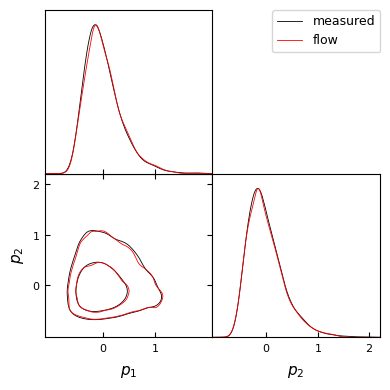

In [24]:
X_sample =  MCSamples(samples=flow.chain)
flow_sample =  MCSamples(samples=flow_chain*flow.std + flow.mean)
weighted_sample = MCSamples(samples=rdsample*flow.std + flow.mean, weights=weights)

gdplt.GetDistPlotSettings()
g = gdplt.get_subplot_plotter()
g.triangle_plot([X_sample, flow_sample], filled=False, legend_labels=['measured', 'flow', 'flow (weights)'])

plt.savefig(os.path.join(plots_dir, 'joint_density_PDF_r{}_r{}_s{}_mu{}{}_normalizingflow.png'.format(r1, r2, sep, mu, '_RSD' if rsd else '')), dpi=500)
plt.show()